In [1]:
import warnings

warnings.filterwarnings("ignore")

### Carregamento dos Dados não Tratados

In [2]:
import pandas as pd

df = pd.read_csv('../../data/creditcard.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])

In [3]:
df.shape
df[df.duplicated()].shape
df.dropna(inplace=True)
df = df.drop_duplicates()

### Escolha do número de Cluster

In [4]:
from sklearn.cluster import KMeans
from tqdm import tqdm

k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

  0%|          | 0/21 [00:00<?, ?it/s]  File "c:\Programming\Github\deteccao-de-fraude\projeto_pad\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


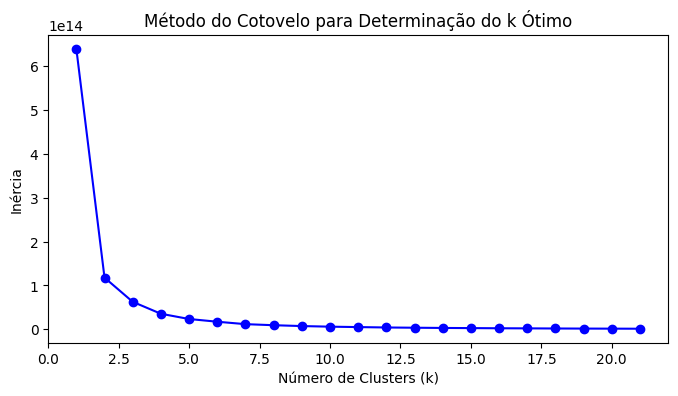

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vamos utilizar um cálculo para podermos encontrar o valor ótimo do número de clusters. Esse cálculo pode ser encontrado nesse blog [https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9].

In [6]:
from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances

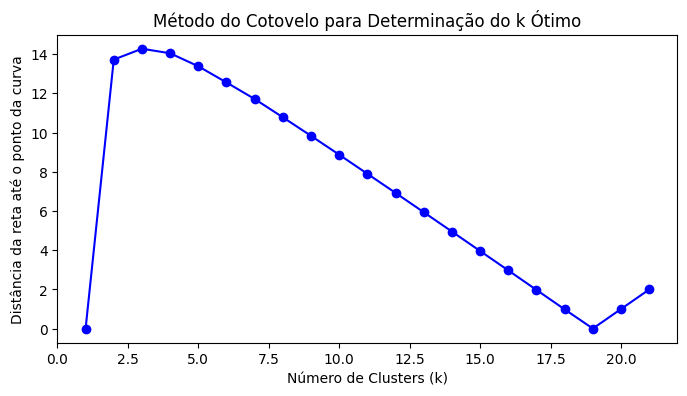

In [7]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vemos que o número ideal de cluster, que possui o maior valor de distância entre a linha e o ponto na curva, é 3. Então podemos trabalhar com 3 clusters para os dados não tratados. Vamos adotar 42 como uma random seed padrão nesse projeto.

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

Com base nos clusters encontrados usamos o "fit_predict" para que o kmeans classifique cada um dos dados dentro do nosso dataframe dentro dos  clusters encontrados

In [9]:
label = kmeans.fit_predict(df)

print("Clusters encontrados",label)
# Aparentemente foi encontrado o cluster 0 como sendo valores grandes, o cluster 1 sendo valores próximos de 0 e o cluster 2 negativos
print(df[label == 2])

Clusters encontrados [2 2 2 ... 1 1 1]
          Time        V1        V2        V3        V4        V5        V6  \
0          0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1          0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
...        ...       ...       ...       ...       ...       ...       ...   
71658  54385.0 -0.316732 -2.724977 -0.179662  1.298446 -1.066954  1.288519   
71659  54385.0  1.093760 -0.566381  1.128984  0.089756 -1.280182 -0.147406   
71660  54386.0 -0.762136  0.666241  1.781871  0.148692  0.240274  0.802121   
71661  54388.0  1.127480 -0.023485  0.704488  0.767368 -0.421560  0.089989   
71662  54389.0 -0.740383  1.259907  2.101816  0.880800  0.129886 -0.933158   

             V7        V

E olha só, ao realizar a visualização do nosso dataset clusterizado, podemos perceber claramente outliers, pois o eixo y está sendo montado com base no PCA, enquanto o x com base no Time, no entanto valores do Time se encontram nos mesmos clusters que dentro do PCA, gerando pontos fora da curva!

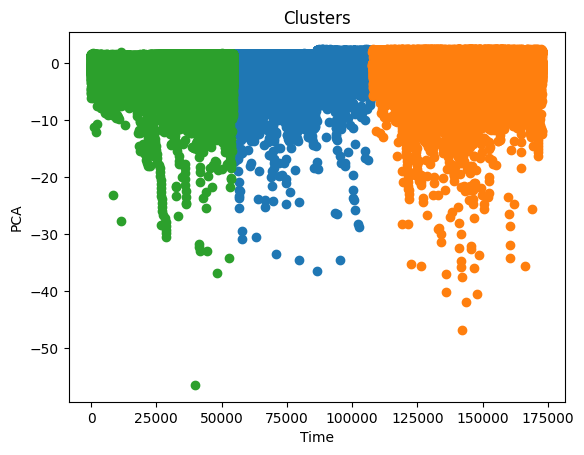

<Figure size 1200x1200 with 0 Axes>

In [10]:
import numpy as np

all_labels = np.unique(label)

for i in all_labels:
    plt.scatter(df[label == i].iloc[:, 0], df[label == i].iloc[:, 1], label=f'Cluster {i}')

plt.ylabel('PCA')
plt.xlabel("Time")
plt.title("Clusters")
plt.figure(figsize=(12,12))
plt.show()

In [11]:
# Obter os centróides do melhor modelo
centroids = kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../../data/best_centroids.csv', index=False)

In [12]:
df['cluster'] = kmeans.labels_
df['Class'] = class_label

df.to_csv('../../data/creditcard_clusters.csv', index=False)

### Carregamento dos Dados Tratados

In [13]:
df = pd.read_csv('../../data/creditcard_treated.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])



In [14]:
df.shape

(566506, 30)

### Escolha do número de Cluster do DF tratado

In [15]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


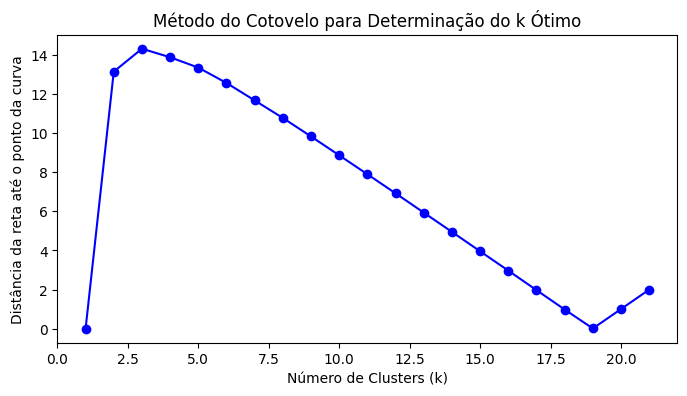

In [16]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Parece que se manteve o mesmo número ideal de clusters... Viva!

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

A inércia está muito mais alta em comparação, o que parece fazer sentido como o volume dos dados dobrou por causa do SMOTE.

In [18]:
label = kmeans.fit_predict(df)

print("Clusters encontrados",label)
#Aparentemente foi encontrado o cluster 0 como sendo valores grandes, o cluster 1 sendo valores próximos de 0 e o cluster 2 negativos
print(df[label == 1])

Clusters encontrados [2 2 2 ... 0 1 1]
                 Time        V1        V2        V3        V4        V5  \
75133    56066.000000  1.296668  0.302840 -0.625996  1.348221  0.753031   
75134    56066.000000 -1.478513  0.048833  1.096862 -1.874985  0.272581   
75135    56066.000000  1.046084 -0.611462  1.107496  0.103029 -1.256433   
75136    56067.000000 -0.316996  0.691807  1.526162  0.068875  0.101911   
75137    56067.000000  1.310652 -0.041430 -1.092743 -0.555089  2.027505   
...               ...       ...       ...       ...       ...       ...   
566493   76778.837205 -0.515939  1.827709 -2.601232  2.610302 -0.570410   
566495   75656.991850 -3.077070  2.433619 -4.217474  4.008425 -3.597976   
566500   90954.027334 -2.021973  2.216909 -1.682328  0.880989 -0.075810   
566504  109361.849259  0.580032  2.773047 -5.790024  5.606953  0.398480   
566505   84438.552579 -2.819178  2.410529 -5.833727  4.099991 -2.622497   

              V6        V7        V8        V9  ...       V2

Podemos perceber pelos gráficos agora com SMOTE que a classificação dos clusters não alterou absurdamente

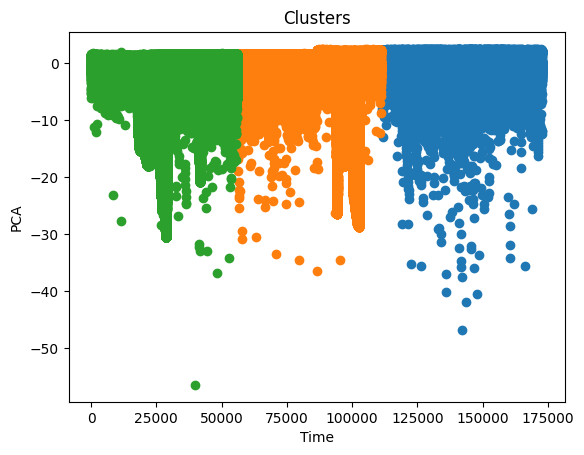

<Figure size 1200x1200 with 0 Axes>

In [19]:
all_labels = np.unique(label)

for i in all_labels:
    plt.scatter(df[label == i].iloc[:, 0], df[label == i].iloc[:, 1], label=f'Cluster {i}')

plt.ylabel('PCA')
plt.xlabel("Time")
plt.title("Clusters")
plt.figure(figsize=(12,12))
plt.show()

In [20]:
# Obter os centróides do melhor modelo
centroids = kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../../data/best_centroids_df_treated.csv', index=False)

In [21]:
df['cluster'] = kmeans.labels_
df['Class'] = class_label

df.to_csv('../../data/creditcard_treated_clusters.csv', index=False)

In [22]:
df = pd.read_csv('../../data/creditcard_treated_clusters.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,cluster,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.238968,2,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.424565,2,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.273308,2,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.121010,2,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.120640,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566501,41183.445750,-7.151786,5.337862,-10.524210,6.638176,-7.107253,-3.688276,-11.629728,4.641323,-6.040679,...,-0.223411,0.029599,0.393875,-0.049155,0.544700,1.306198,0.223600,-0.357981,2,1
566502,14264.057012,-4.705909,8.250299,-14.559164,9.787990,-4.117161,-3.169121,-10.169571,4.500750,-5.177936,...,0.194092,0.480124,-1.079562,-0.444215,0.557467,1.234855,0.627900,-0.429040,2,1
566503,135064.971368,0.407366,1.352354,-4.892782,3.554728,-1.282114,-1.271505,-0.977517,0.462476,-1.442286,...,0.703300,0.814076,0.814930,-0.300969,0.168339,0.236775,0.037244,0.841150,0,1
566504,109361.849259,0.580032,2.773047,-5.790024,5.606953,0.398480,-0.621865,-2.954884,0.837074,-1.822486,...,-0.810361,-0.067584,-0.632356,0.414552,0.073243,0.736440,0.358067,-0.417994,1,1


### Utilizando Autoencoders para Reduzir a dimensionalidade antes de utilizar o Kmeans

In [27]:
import keras
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model


df_autoencoder = pd.read_csv('../../data/creditcard_treated.csv')


In [29]:
X_train, X_test = train_test_split(df_autoencoder, test_size=0.3, random_state=42)

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42)

input = layers.Input(shape=(X_train.shape[1],))

encoded = layers.Dense( units = 31, activation = "relu")(input)

decoded = layers.Dense( units = 31, activation = "sigmoid")(encoded)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer = "adam",loss = "binary_crossentropy", metrics = ["accuracy"])
autoencoder.summary()

autoencoder.fit(X_train, X_train, epochs = 2, batch_size = 32, validation_data = (X_test, X_test))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 31)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │           992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,984 (7.75 KB)

 Trainable params: 1,984 (7.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 1.0000 - loss: -101928099840.0000 - val_accuracy: 1.0000 - val_loss: -809787523072.0000
Epoch 2/2
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 1.0000 - loss: -1247653003264.0000 - val_accuracy: 1.0000 - val_loss: -2992725819392.0000


In [30]:
loss_train = autoencoder.evaluate(X_train, X_train)
loss_test = autoencoder.evaluate(X_test, X_test)
loss_val = autoencoder.evaluate(X_val, X_val)

print("Perda no conjunto de treinamento:", loss_train)
print("Perda no conjunto de validação:", loss_val)
print("Perda no conjunto de teste:", loss_test)

12393/12393 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 1.0000 - loss: -2993616584704.0000
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: -2998286680064.0000
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: -2984951152640.0000
Perda no conjunto de treinamento: [-2993068703744.0, 0.9999924302101135]
Perda no conjunto de validação: [-2993574903808.0, 1.0]
Perda no conjunto de teste: [-2992725819392.0, 0.9999882578849792]


In [31]:
encoder_model = Model(input,encoded)

X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

12393/12393 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step


Utilizando Kmeans para clusterizar os dados após reduzir sua dimensinalidade utilizando Autoencoders

In [32]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_encoded)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


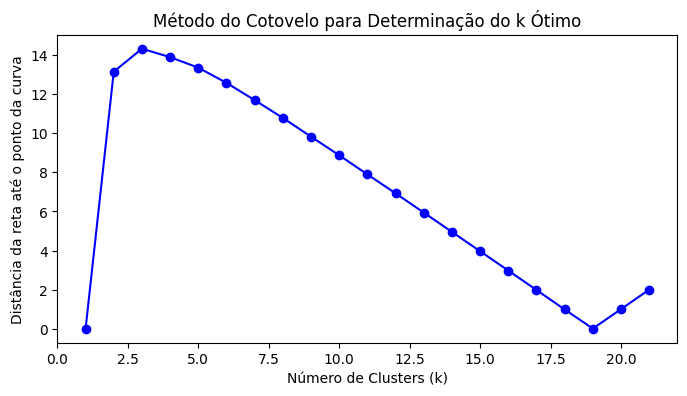

In [33]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

Calculando a Inércia, percebemos que teve uma melhora de 000000000135734.53, em relação a anterior(sem autoencoders), isso pode ser devido ao fato de que o PCA já 
havia sido aplicado nos dados

In [35]:
print(f"Inércia: {kmeans.inertia_}")

Inércia: 127339646774125.8


In [36]:
label = kmeans.fit_predict(df)

print("Clusters encontrados",label)
#Aparentemente foi encontrado o cluster 0 como sendo valores grandes, o cluster 1 sendo valores próximos de 0 e o cluster 2 negativos
print(df[label == 1])

Clusters encontrados [2 2 2 ... 0 1 1]
                 Time        V1        V2        V3        V4        V5  \
75133    56066.000000  1.296668  0.302840 -0.625996  1.348221  0.753031   
75134    56066.000000 -1.478513  0.048833  1.096862 -1.874985  0.272581   
75135    56066.000000  1.046084 -0.611462  1.107496  0.103029 -1.256433   
75136    56067.000000 -0.316996  0.691807  1.526162  0.068875  0.101911   
75137    56067.000000  1.310652 -0.041430 -1.092743 -0.555089  2.027505   
...               ...       ...       ...       ...       ...       ...   
566493   76778.837205 -0.515939  1.827709 -2.601232  2.610302 -0.570410   
566495   75656.991850 -3.077070  2.433619 -4.217474  4.008425 -3.597976   
566500   90954.027334 -2.021973  2.216909 -1.682328  0.880989 -0.075810   
566504  109361.849259  0.580032  2.773047 -5.790024  5.606953  0.398480   
566505   84438.552579 -2.819178  2.410529 -5.833727  4.099991 -2.622497   

              V6        V7        V8        V9  ...       V2

O uso de autoencoders não foi tão benefico para esse conjunto de dados, como pode ser observado na imagem

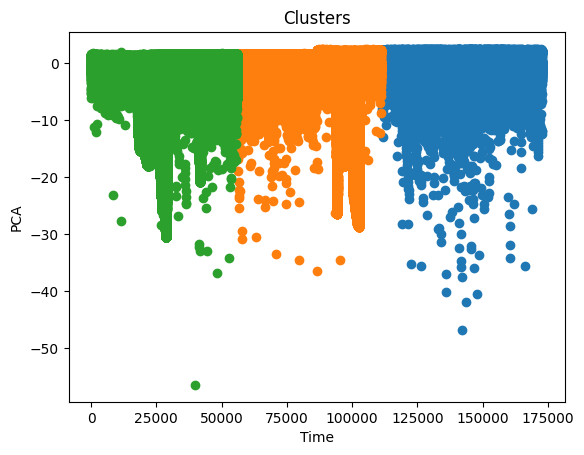

<Figure size 1200x1200 with 0 Axes>

In [37]:
all_labels = np.unique(label)

for i in all_labels:
    plt.scatter(df[label == i].iloc[:, 0], df[label == i].iloc[:, 1], label=f'Cluster {i}')

plt.ylabel('PCA')
plt.xlabel("Time")
plt.title("Clusters")
plt.figure(figsize=(12,12))
plt.show()